__CS 6643 - Computer Vision, Spring 2024__

Project 2, Due Date: March 15, 2024

Name: Runze Li

Net id: rl50xx

### Convolution and Derivative Filters

#### Correlation/Convolution

Implement 2D convolution (denoted `*`) __without the use of built in functions.__ Your function will take as input two 2D arrays, a filter `f` and an image `I`, and return `f∗I`. You can handle the boundary of `I` in any reasonable way of your choice, such as padding with zeros based on the size of the filter `f`. You are free to make use of any part of your previous indexing implementation.

Make the convolution module flexible to receive 1D line filters (used for separable filtering) and also masks representing image templates (used in the second question below).

Please note that all processing is __done in floating point__ and not on byte images. As a first step, convert input images into float arrays, and also use float arrays for all the processing steps. Would you not have a display of floats, you can at the very end convert the results back to byte or integers.

In [1]:
import numpy as np

In [2]:
def convolution(f, I):
    # Handle boundary of I, e.g. pad I according to size of f
    
    im_conv = np.zeros(shape=I.shape)
    
    if len(f.shape) == 1:
        if f.shape[0] > 1:
            f = np.flipud(f)
        else:
            f = np.fliplr(f)
    else:
        f = np.flipud(np.fliplr(f))
    
    if len(f.shape) == 1:
        f = f.reshape(1, len(f))
        hori_padding = f.shape[1] // 2
        vert_padding = 0
    else: 
        if f.shape[1] > 1:
            hori_padding = f.shape[1] // 2
        else:
            hori_padding = 0
        vert_padding = f.shape[0] // 2
    
    padded_image = np.zeros(shape=(I.shape[0] + 2*vert_padding,
                                   I.shape[1] + 2*hori_padding))
    
    padded_image[vert_padding:padded_image.shape[0]-vert_padding,
                 hori_padding:padded_image.shape[1]-hori_padding]=I

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            section = padded_image[i:i+f.shape[0], j:j+f.shape[1]]
            im_conv[i,j] = np.sum(section*f)
    
    # Compute im_conv = f*I
    return im_conv

In [3]:
# 测试示例
f = np.array([[0.0, 0.1, 0.0],
              [0.1, 0.6, 0.1],
              [0.0, 0.1, 0.0]])
# f = np.array([[1, 0, -1],
#               [1, 0, -1],
#               [1, 0, -1]])
# f = np.array([[-1, -1, -1],
#               [0, 0, 0],
#               [1, 1, 1]])
# f = np.array([-1, 0, 1])

I = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12]])

# result = cross_correlation(f, I)
# print("Cross correlation:")
# print(result)
result = convolution(f, I)
print("Convolution:")
print(result)

Convolution:
[[1.3 2.2 3.1 3.5]
 [4.6 6.  7.  7.1]
 [6.9 8.6 9.5 9.1]]


#### Edge Detection Filtering

Using the example image `cameraman.png` or `zebra.png`.

All operations have to be performed with floating point images and operation, only for output and report you would convert back to byte `[0..255]` images.

Denoise the image with a Gaussian filter. Please remember the in class demo and pdf description (uploaded to Brightspace) to create a 1D Gaussian filter, but you must use your own implementation of convolution. Use separability to consecutively filter first with a horizontal 1D Gaussian `Gx` and second a vertical 1D Gaussian `Gy`. Reasonable choices are Gaussian width of sigma 2.0 or 3.0, with filter sizes of `3*sigma` to the left and the right, which results in filter widths of `6*sigma+1`.

In [4]:
import cv2
import matplotlib.pyplot as plt

In [5]:
def gaussian_1d(sigma, width):
    # Create a 1D Gaussian filter.
    kernel = np.zeros(width)
    center = width // 2
    for x in range(width):
        kernel[x] = np.exp(-((x - center) ** 2) / (2 * sigma ** 2))
    kernel /= np.sum(kernel)
    return kernel

In [6]:
def gaussian_filter(image, sigma, size):
    # Apply Gaussian filter to the image using separable convolution.
    # Generate 1D Gaussian kernels
    Gx = gaussian_1d(sigma, size)
    # Transpose for vertical convolution
    Gy = np.transpose([Gx])

    # Apply horizontal convolution
    convolved_x = convolution(Gx, image)
    # Apply vertical convolution
    convolved_y = convolution(Gy, convolved_x)

    return convolved_y

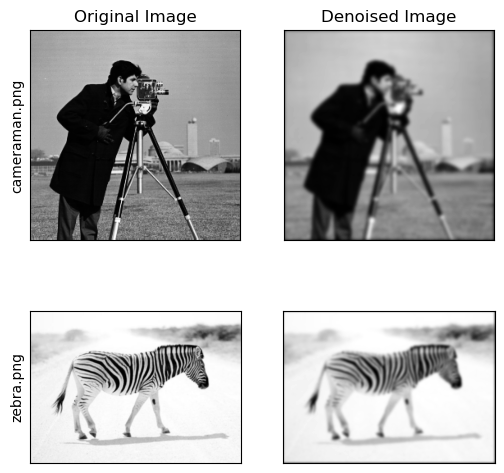

In [7]:
# Load image
images = ['cameraman.png', 'zebra.png']

# Parameters
sigma = 2.0
# Filter size based on sigma
size = int(6 * sigma) + 1

fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for i in range(len(images)):
    image = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE).astype(np.float32)
    axs[i, 0].imshow(image, cmap='gray')
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])
    axs[i, 0].set_ylabel(images[i])
    
    # Apply Gaussian filter
    denoised_image = gaussian_filter(image, sigma, size)
    # Convert back to byte [0, 255]
    denoised_image = np.clip(denoised_image, 0, 255).astype(np.uint8)
    axs[i, 1].imshow(denoised_image, cmap='gray')
    axs[i, 1].set_xticks([])
    axs[i, 1].set_yticks([])

axs[0, 0].set_title("Original Image")
axs[0, 1].set_title("Denoised Image")
plt.show()

##### Version via first derivatives:

- Compute derivative images (with respect to x and with respect to y) using the separable derivative filter of your choice, e.g. `[-1 0 1]` and `[-1 0 1]T`. You can hardcode the derivative filter, but use your implementation of convolution.
- Compute the gradient magnitude image that combines x- and y-derivatives.
- Create binary edge images from the gradient magnitude image using a threshold of your choice (trial and error till you like the result).

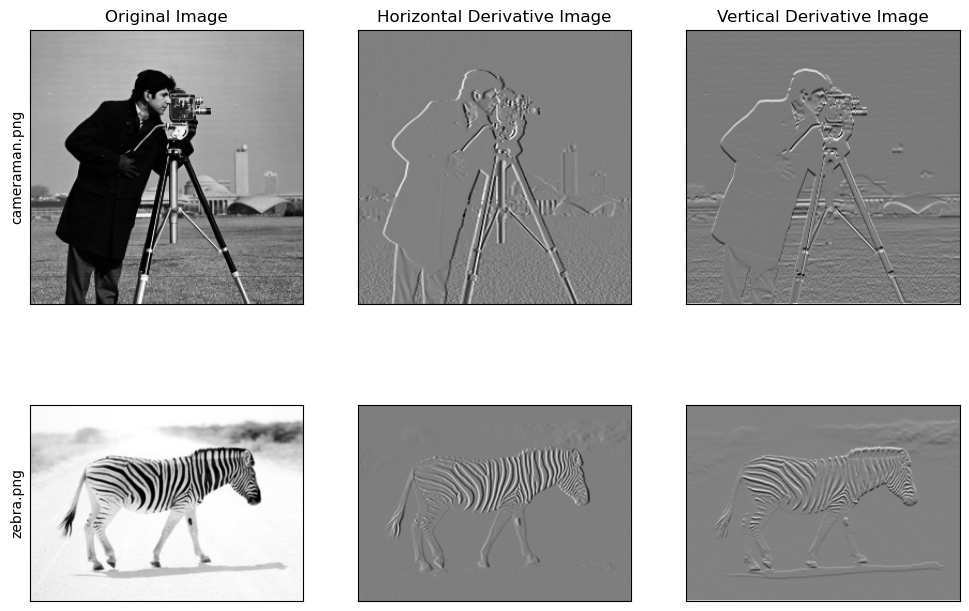

In [8]:
fx = np.array([[-1, 0, 1]], dtype=np.float32)
fy = np.transpose(fx)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i in range(len(images)):
    image = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE).astype(np.float32)
    axs[i, 0].imshow(image, cmap='gray')
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])
    axs[i, 0].set_ylabel(images[i])
    
    Gx = convolution(fx, image)
    axs[i, 1].imshow(Gx, cmap='gray')
    axs[i, 1].set_xticks([])
    axs[i, 1].set_yticks([])
    
    Gy = convolution(fy, image)
    axs[i, 2].imshow(Gy, cmap='gray')
    axs[i, 2].set_xticks([])
    axs[i, 2].set_yticks([])

axs[0, 0].set_title("Original Image")
axs[0, 1].set_title("Horizontal Derivative Image")
axs[0, 2].set_title("Vertical Derivative Image")
plt.show()

In [9]:
def gradient_magnitude(derivative_x, derivative_y):
    # Compute gradient magnitude image.
    gradient_magnitude = np.sqrt(derivative_x**2 + derivative_y**2)
    return gradient_magnitude

In [10]:
def manual_threshold(im_in, threshold):
    # Threshold image with the threshold of your choice
    manual_thresh_img = np.zeros_like(im_in)
    manual_thresh_img[im_in > threshold] = 255
    return manual_thresh_img

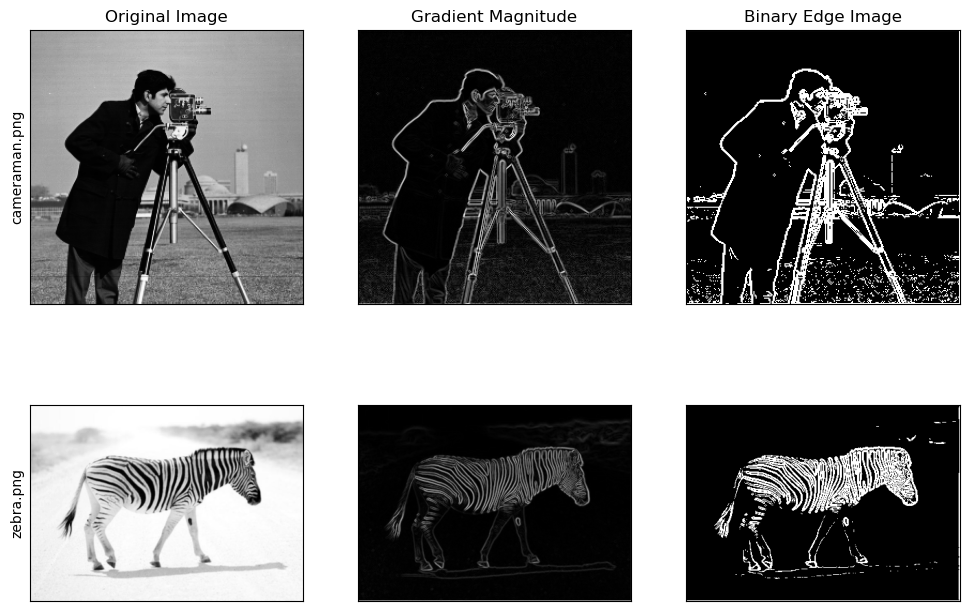

In [11]:
threshold = 45

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i in range(len(images)):
    image = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE).astype(np.float32)
    axs[i, 0].imshow(image, cmap='gray')
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])
    axs[i, 0].set_ylabel(images[i])
    
    Gx = convolution(fx, image)
    Gy = convolution(fy, image)
    G = gradient_magnitude(Gx, Gy)
    axs[i, 1].imshow(G, cmap='gray')
    axs[i, 1].set_xticks([])
    axs[i, 1].set_yticks([])
    
    binary_edge_images = manual_threshold(G, threshold)
    axs[i, 2].imshow(binary_edge_images, cmap='gray')
    axs[i, 2].set_xticks([])
    axs[i, 2].set_yticks([])
    
axs[0, 0].set_title("Original Image")
axs[0, 1].set_title("Gradient Magnitude")
axs[0, 2].set_title("Binary Edge Image")
plt.show()

##### Version via zero-crossings of second derivative

- Based on the Gaussian-smoothed image, apply a 3x3 Laplacian filter to mimick the 2nd derivative in 2D: `[[0,-1,0],[-1,4,-1],[0,-1,0]]`. 
- Write a 3x3 procedure for detection of zero-crossings following the rule "to find pixels with positive values that have at least one negative neighbor": 
    - Scan the Laplacian filtered Gaussian-smoothed image, for each pixel which is positive, check all 8 neighbors for negative pixels. 
    - An edge is found and marked in the output image if there is at least one negative pixel, resulting in an image where all edges are found, even in the noise.
    - __Better:__ You can additionally filter for strong edges (strong slopes) if you only select negative pixels which show at least a difference value __delta or more__ to your positive center pixel. The value __delta__ is a heuristic choice which you select by trial and error.
- The output is an edge image with thin lines of mostly one-pixel width.

In [12]:
def zero_crossing(image):
    edge_image = np.zeros_like(image)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            center_value = image[i, j]
            if center_value > 0:
                # Check the 8 neighbors
                neighbors = image[i-1:i+2, j-1:j+2].flatten()
                # Exclude the center pixel
                neighbors = np.delete(neighbors, 4)
                # If any neighbor is negative, mark as edge.
                if any(n < 0 for n in neighbors):
                    edge_image[i, j] = 255
    return edge_image

In [13]:
def zero_crossing_with_delta(image, delta=0):
    edge_image = np.zeros_like(image)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            center_value = image[i, j]
            if center_value > 0:
                # Check the 8 neighbors
                neighbors = image[i-1:i+2, j-1:j+2].flatten()
                # Exclude the center pixel
                neighbors = np.delete(neighbors, 4)
                if any(n < 0 and center_value - n > delta for n in neighbors):
                    edge_image[i, j] = 255
    return edge_image

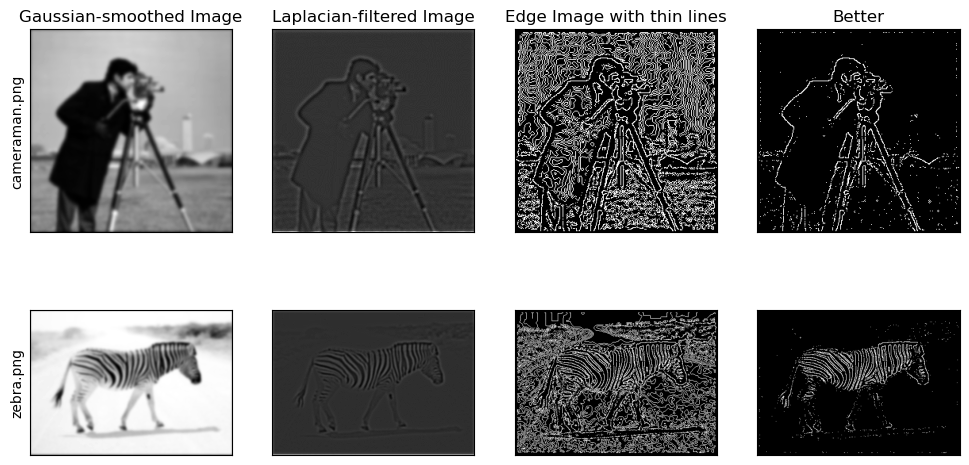

In [14]:
# Load image
images = ['cameraman.png', 'zebra.png']

laplacian_filter = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

# Parameters
sigma = 2.0
# Filter size based on sigma
size = int(6 * sigma) + 1

fig, axs = plt.subplots(2, 4, figsize=(12, 6))

for i in range(len(images)):
    image = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE).astype(np.float32)
    
    # Apply Gaussian filter
    gaussian_smoothed_image = gaussian_filter(image, sigma, size)
    # Convert back to byte [0, 255]
    gaussian_smoothed_image = np.clip(gaussian_smoothed_image, 0, 255).astype(np.uint8)
    axs[i, 0].imshow(gaussian_smoothed_image, cmap='gray')
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])
    axs[i, 0].set_ylabel(images[i])
    
    # Apply the Laplacian filter
    laplacian_image = convolution(laplacian_filter, gaussian_smoothed_image) # Assuming gaussian_blurred_image is already computed
    axs[i, 1].imshow(laplacian_image, cmap='gray')
    axs[i, 1].set_xticks([])
    axs[i, 1].set_yticks([])
    
    # Detect edges
    edge_image = zero_crossing(laplacian_image)
    axs[i, 2].imshow(edge_image, cmap='gray')
    axs[i, 2].set_xticks([])
    axs[i, 2].set_yticks([])
    
    # Detect edges Better!
    edge_image_with_data = zero_crossing_with_delta(laplacian_image, delta=5)  # Adjust delta as needed
    axs[i, 3].imshow(edge_image_with_data, cmap='gray')
    axs[i, 3].set_xticks([])
    axs[i, 3].set_yticks([])
    

axs[0, 0].set_title("Gaussian-smoothed Image")
axs[0, 1].set_title("Laplacian-filtered Image")
axs[0, 2].set_title("Edge Image with thin lines")
axs[0, 3].set_title("Better")
plt.show()

Show all image results, also from intermediate steps, and discuss the outcome together with your choice of thresholds: Original image, x- and y-derivatives, magnitude image, thresholded magnitude image, Laplacian-filtered image, edge image.

Note that the x- and y-derivative, magnitude and Lapacian images may be either signed values with positive/negative values, or very dark when displayed. Here, it is best to stretch their values from `[Min-Max]` to 
`[0..255]` just for display. 

Best is to write a small __subroutine "ImageAdjust"__ to a) calculate Min/Max of our image array and b) adjust these values from `[0..255]` for output to a byte image.

### Cross-correlation and Template Matching

The uploaded image `animal-family-25.jpg` is a single image containing multiple instances of different objects. 

To detect and count objects, perform the following steps:

- Use the template image `animal-family-25-template.jpg` as your filter-mask.
- Convert the original byte image and template to float when reading them into your program.
- Prepare the template image as follows:
    - Calculate the min, max and mean value of the template image.
    - Normalize the template image by subtracting the mean value from all pixel values, so that the mean of the resulting template becomes 0.0. This will be your zero-mean template. 

Minimum value: 0
Maximum value: 255
Mean value: 135.27836163836164
New mean value: 5.5242035831962075e-15


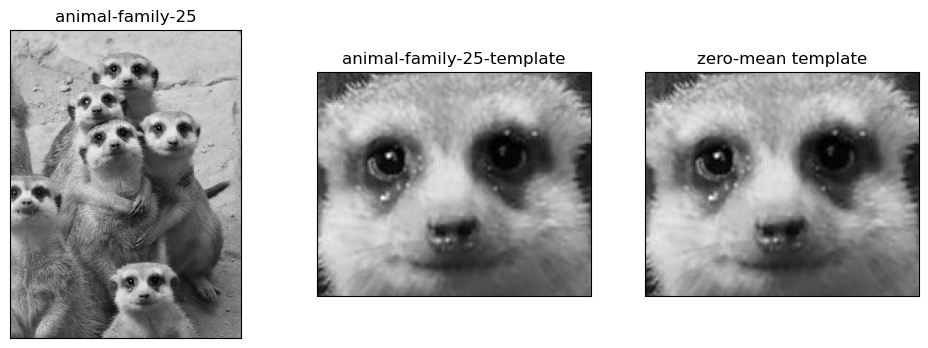

In [15]:
image = cv2.imread('animal-family-25.jpg', 0)
image_template = cv2.imread('animal-family-25-template.jpg', 0)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(image, cmap='gray')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('animal-family-25')
axs[1].imshow(image_template, cmap='gray')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('animal-family-25-template')

# Calculate min, max, and mean values
min_val = np.min(image_template)
max_val = np.max(image_template)
mean_val = np.mean(image_template)
print(f"Minimum value: {min_val}")
print(f"Maximum value: {max_val}")
print(f"Mean value: {mean_val}")
# Normalize the template image to have a zero mean
zero_mean_template = image_template - mean_val
# Verify the new mean is close to 0.0
new_mean_val = np.mean(zero_mean_template)
print(f"New mean value: {new_mean_val}")
axs[2].imshow(zero_mean_template, cmap='gray')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('zero-mean template')

plt.show()

- Implement cross-correlation with the original image and the zero-mean template image as mask. Please note that this mask is not separable. 

In [16]:
def cross_correlation(f, I):
    im_corr = np.zeros(shape=I.shape)
    
    if len(f.shape) == 1:
        f = f.reshape(1, len(f))
        hori_padding = f.shape[1] // 2
        vert_padding = 0
    else: 
        if f.shape[1] > 1:
            hori_padding = f.shape[1] // 2
        else:
            hori_padding = 0
        vert_padding = f.shape[0] // 2
    
    padded_image = np.zeros(shape=(I.shape[0] + 2*vert_padding,
                                   I.shape[1] + 2*hori_padding))
    
    padded_image[vert_padding:padded_image.shape[0]-vert_padding,
                 hori_padding:padded_image.shape[1]-hori_padding]=I

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            section = padded_image[i:i+f.shape[0], j:j+f.shape[1]]
            im_corr[i,j] = np.sum(section*f)
    
    return im_corr

- Please recall that this filtering results in peak values (maxima) if the template matches the specific image region which was selected for extracting your template.
- Apply the procedure `ImageAdjust` from task 1 to the correlation image, so that maxima show values closer to 255.
- Own experiments show that thresholding of the adjusted correlation image at 60% of 255 (150) generates peaks for the whole family, and results in a byte image of the resulting peaks.
- Overlay the peaks onto the original image for checking (TAs will provide a hint on an existing script).

In [17]:
def image_adjust(image):
    # Calculate the minimum and maximum pixel values of the image
    min_val = np.min(image)
    max_val = np.max(image)
    # Scale the image values to the [0, 255] range
    adjusted_image = 255 * (image - min_val) / (max_val - min_val)
    return adjusted_image.astype(np.uint8)

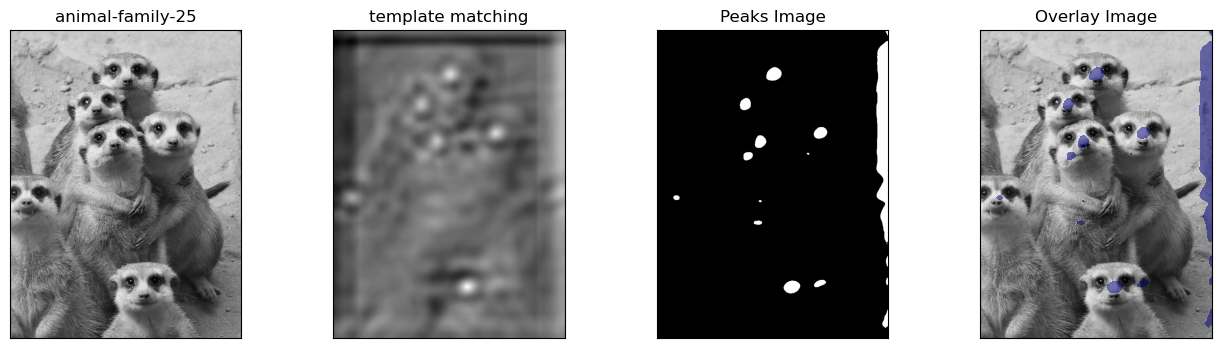

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].imshow(image, cmap='gray')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('animal-family-25')

template_matching = cross_correlation(zero_mean_template, image)
template_matching = image_adjust(template_matching)
axs[1].imshow(template_matching, cmap='gray')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('template matching')

threshold = 150
peaks_image = manual_threshold(template_matching, threshold)
axs[2].imshow(peaks_image, cmap='gray')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('Peaks Image')

axs[3].imshow(image, cmap='gray')
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[3].set_title('Overlay Image')
axs[3].imshow(np.ma.masked_where(peaks_image == 0, peaks_image), cmap='jet', alpha=0.5, interpolation='nearest')

plt.show()

- In your report, show the original image, peak image (output of cross-correlation), binarized peak image and overlay. Experiment with higher thresholds and report what you see, eventually not detecting all animals?

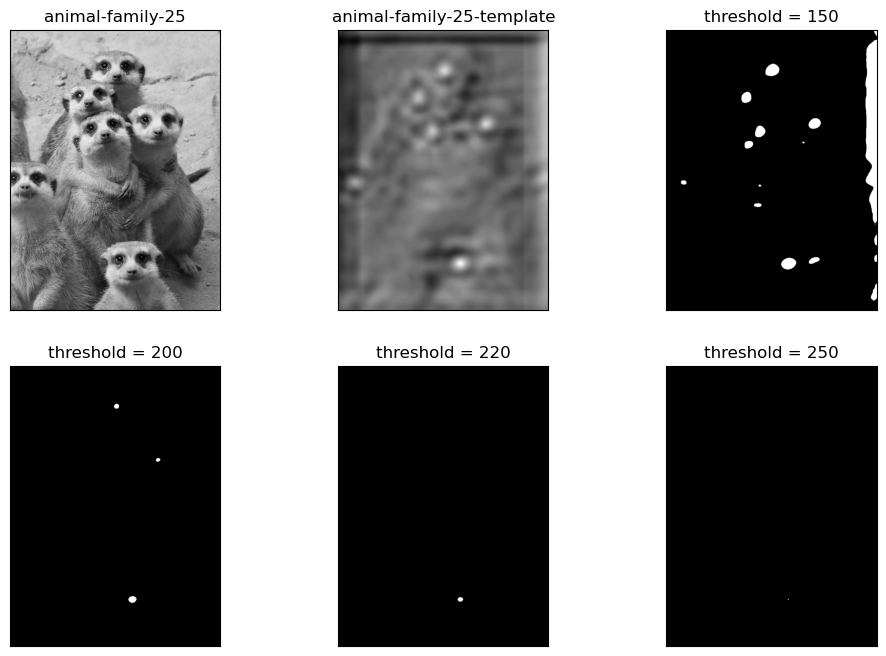

In [19]:
thresholds = [150, 200, 220, 250]

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].imshow(image, cmap='gray')
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[0, 0].set_title('animal-family-25')
axs[0, 1].imshow(template_matching, cmap='gray')
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].set_title('animal-family-25-template')

peaks_image_150 = manual_threshold(template_matching, thresholds[0])
axs[0, 2].imshow(peaks_image_150, cmap='gray')
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])
axs[0, 2].set_title('threshold = 150')

peaks_image_200 = manual_threshold(template_matching, thresholds[1])
axs[1, 0].imshow(peaks_image_200, cmap='gray')
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
axs[1, 0].set_title('threshold = 200')

peaks_image_220 = manual_threshold(template_matching, thresholds[2])
axs[1, 1].imshow(peaks_image_220, cmap='gray')
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[1, 1].set_title('threshold = 220')

peaks_image_250 = manual_threshold(template_matching, thresholds[3])
axs[1, 2].imshow(peaks_image_250, cmap='gray')
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])
axs[1, 2].set_title('threshold = 250')

plt.show()

- Include all results and discussion in your report. Remember your report needs to be a standalone document that someone outside of class can follow.

### Creative Part (Bonus)

You may now use your filtering modules to solve problems of your choice, below just a few ideas you may  want to pursue:

1. __Counting cars in a car manufacturer’s lot__ (e.g. [link](https://www.alamy.com/new-multi-colored-passenger-cars-are-standing-in-straight-diagonal-rows-in-a-giant-parking-lot-on-the-territory-of-the-plant-aerial-view-image454712514.html?imageid=3C3E40F0-AEF9-43CC-BF2E-4B2717DE2532&p=556177&pn=1&searchId=c1c41d7ac73a1205241ae3938a03e6e3&searchtype=0) or [link2](https://www.alamy.com/aerial-top-view-new-cars-lined-up-in-the-port-for-import-export-business-logistic-and-transportation-by-ship-in-the-open-sea-new-car-from-the-factory-image340952369.html?imageid=4D4288EC-9B81-4D90-AED9-8A1BB987749D&p=226327&pn=1&searchId=c1c41d7ac73a1205241ae3938a03e6e3&searchtype=0)). A manufacturer may want to know how many cars of a specific type are parked on its parking lot. Procedure same as .in 2).

2. __Sorting by similarity__: Peak images show different strengths of objects that deviate from the template itself (best is to check this with the animal picture). Using connected component labeling on thresholded peak images as in 1), you could detect the maximum peak value within each connected component and sort them by size. More animal family pictures are found at [https://www.boredpanda.com/animal-family-portraits/](https://www.boredpanda.com/animal-family-portraits/) , you may experiment with others.

3. __Etc__

Total cars in the parking lot: 200


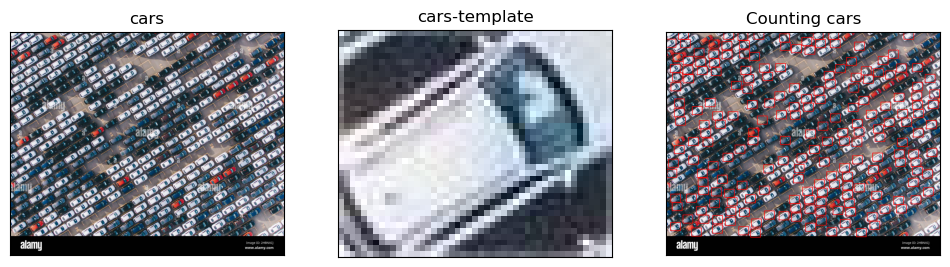

In [20]:
image = cv2.imread('cars.jpg')
template = cv2.imread('cars-template.jpg')

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('cars')
axs[1].imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('cars-template')

res = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
threshold = 0.5
loc = np.where(res >= threshold)
processed_points = set()

(h, w) = template.shape[:2]
for pt in zip(*loc[::-1]):
    # Check if this point is close to others already processed
    if any(abs(pt[0] - processed_pt[0]) <= w and abs(pt[1] - processed_pt[1]) <= h for processed_pt in processed_points):
        continue
    cv2.rectangle(image, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
    processed_points.add(pt)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Total cars in the parking lot:", len(processed_points))

axs[2].imshow(image_rgb)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('Counting cars')
plt.show()